The following notebook implements anomaly augmentations on the background dataset to create a "fake" signal dataset.

These augmentations were originally devised in [1] with the [original code available here](https://github.com/bmdillon/AnomalyCLR/blob/main/EventLevelAnomalyAugmentations.py).

The following code implements an improved version of these functions.

--

[1] *B.M. Dillon, L. Favaro, F. Feiden, T. Modak, T. Plehn. "Anomalies, Representations, and Self-Supervision."* [arXiv: 2301.04660](https://arxiv.org/abs/2301.04660).


# Preliminaries

## Google Drive preliminaries (since we're running on Google Colab)

In [ ]:
#-- "Mount" Google Drive to access data and save files/images --#
# NOTE: If running locally, comment out this cell and change the basePath accordingly
# Reference: https://stackoverflow.com/questions/49031798/when-i-use-google-colaboratory-how-to-save-image-weights-in-my-google-drive
from google.colab import drive
drive.mount('/content/gdrive')

# You will be asked to sign into a Google account and give GoogleColab access

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# To check that mounting worked, uncomment and run the following. You should see the contents of the directory listed.
! ls '/content/gdrive/My Drive/Research/AnomalyDetectionWithOT/OnML4Jets2021DataChallenge/Data/'

anomalyAugmented_background_for_training_50k.h5  hChToTauNu_13TeV_PU20_filtered.h5
anomalyAugmented_background_for_training.h5	 hToTauTau_13TeV_PU20_filtered.h5
Ato4l_lepFilter_13TeV_filtered.h5		 leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5
background_for_training.h5			 OldBuggedDatasets
BlackBox_background_mix.h5


In [ ]:
#-- Set base directory and data directory path --#
basePath   = '/content/gdrive/My Drive/Research/AnomalyDetectionWithOT/OnML4Jets2021DataChallenge/'
dataPath   = 'Data/'

bkgPath    = basePath+dataPath+'background_for_training.h5'

## Import libraries

We'll eventually be using the PyOT library to compute Wasserstein distances for now (see [here](https://pythonot.github.io/index.html)). But since this notebook is just visualizing the data we won't use it yet.

In [ ]:
import numpy as np
from numpy.random import RandomState
import numpy.ma as ma

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline

import h5py
from numpy.random import Generator, PCG64
from sklearn import metrics
import itertools

## Functions

To keep things tidy, functions are externally defined in `centralFunctions.ipynb`. We run this notebook from here which defines the contained functions as if they were written here.


In [ ]:
%cd /content/gdrive/My Drive/Research/AnomalyDetectionWithOT/OnML4Jets2021DataChallenge/
%run centralFunctions.ipynb

/content/gdrive/My Drive/Research/AnomalyDetectionWithOT/OnML4Jets2021DataChallenge


## Load data

For more details on the data structure, see [this exploratory notebook](https://colab.research.google.com/drive/138CL8n4gCtramqaaI-i0EUZ7n4f1SWVh?usp=sharing).

In [ ]:
dataDict = {}
dataDict['bkg'] = h5py.File(bkgPath, 'r')

# Anomaly augment data

In [ ]:
augDataSavePath = 'Data/anomalyAugmented_background_for_training.h5'
augmentAndSaveData(dataDict, saveFilePath=augDataSavePath, batchSize=5000, nEvents=None, DEBUG=False)

## 50k for testing
#augDataSavePath = 'Data/anomalyAugmented_background_for_training_50k.h5'
#augmentAndSaveData(dataDict, saveFilePath=augDataSavePath, batchSize=5000, nEvents=50000, DEBUG=False)

Processing 13451915 events
2690 batches with size 5000 with one more batch of size 1915
Saving data to  Data/anomalyAugmented_background_for_training.h5


100%|██████████| 2691/2691 [22:10<00:00,  2.02it/s]


# Estimate of how many background events cannot have augmentation (2) applied?

In [ ]:
bkgData = dataDict['bkg']['Particles']
print(bkgData.shape)

(13451915, 19, 4)


In [ ]:
N = 100000
nInvalidList = []
start=0
for i in range(5):
  end = start+N
  B = bkgData[start:end,:,:]
  newB = format_for_anomalyAugmentations(B)
  mask = aug_2_conditions(newB, minJetBase=15., minLeptonBase=3., minLeadingpT=23.)
  nInvalidList.append(N-mask.sum())
  start=end

  print("Out of %d background events, augmentation (2) is invalid for %d of them."%(N, nInvalidList[i]))
  # mask.sum() counts the number of True elements (i.e. when augmentation 2 is okay)


Out of 100000 background events, augmentation (2) is invalid for 8058 of them.
Out of 100000 background events, augmentation (2) is invalid for 8215 of them.
Out of 100000 background events, augmentation (2) is invalid for 8357 of them.
Out of 100000 background events, augmentation (2) is invalid for 8015 of them.
Out of 100000 background events, augmentation (2) is invalid for 8217 of them.


In [ ]:
mean, std = np.mean(np.array(nInvalidList)), np.std(np.array(nInvalidList))
print("Mean +- std: ", mean, std)
print("As percentage", 100*(mean/N), 100*(std/N) )

Mean +- std:  8172.4 123.07981150456806
As percentage 8.1724 0.12307981150456807


This means that augmentation (2) is invalid for $8.1724 \pm 0.1231 \%$ of events

# Test and visualize augmented data

In [ ]:
#-- Open file --#
newAugBkgData = h5py.File('Data/anomalyAugmented_background_for_training_50k.h5', 'r')['augBkg']
print(newAugBkgData.shape)

bkgData       = dataDict['bkg']['Particles'][0:newAugBkgData.shape[0], :, :]
print(bkgData.shape)

(50000, 19, 4)
(50000, 19, 4)


In [ ]:
# Ensure that augmented events pass selection criteria
print(np.all(check_data(newAugBkgData)))

             phiCheck pass?  True
         eta_eleCheck pass?  True
          eta_muCheck pass?  True
         eta_jetCheck pass?  True
        pT_eleMuCheck pass?  True
pT_leadingLeptonCheck pass?  True
          pT_jetCheck pass?  True
True


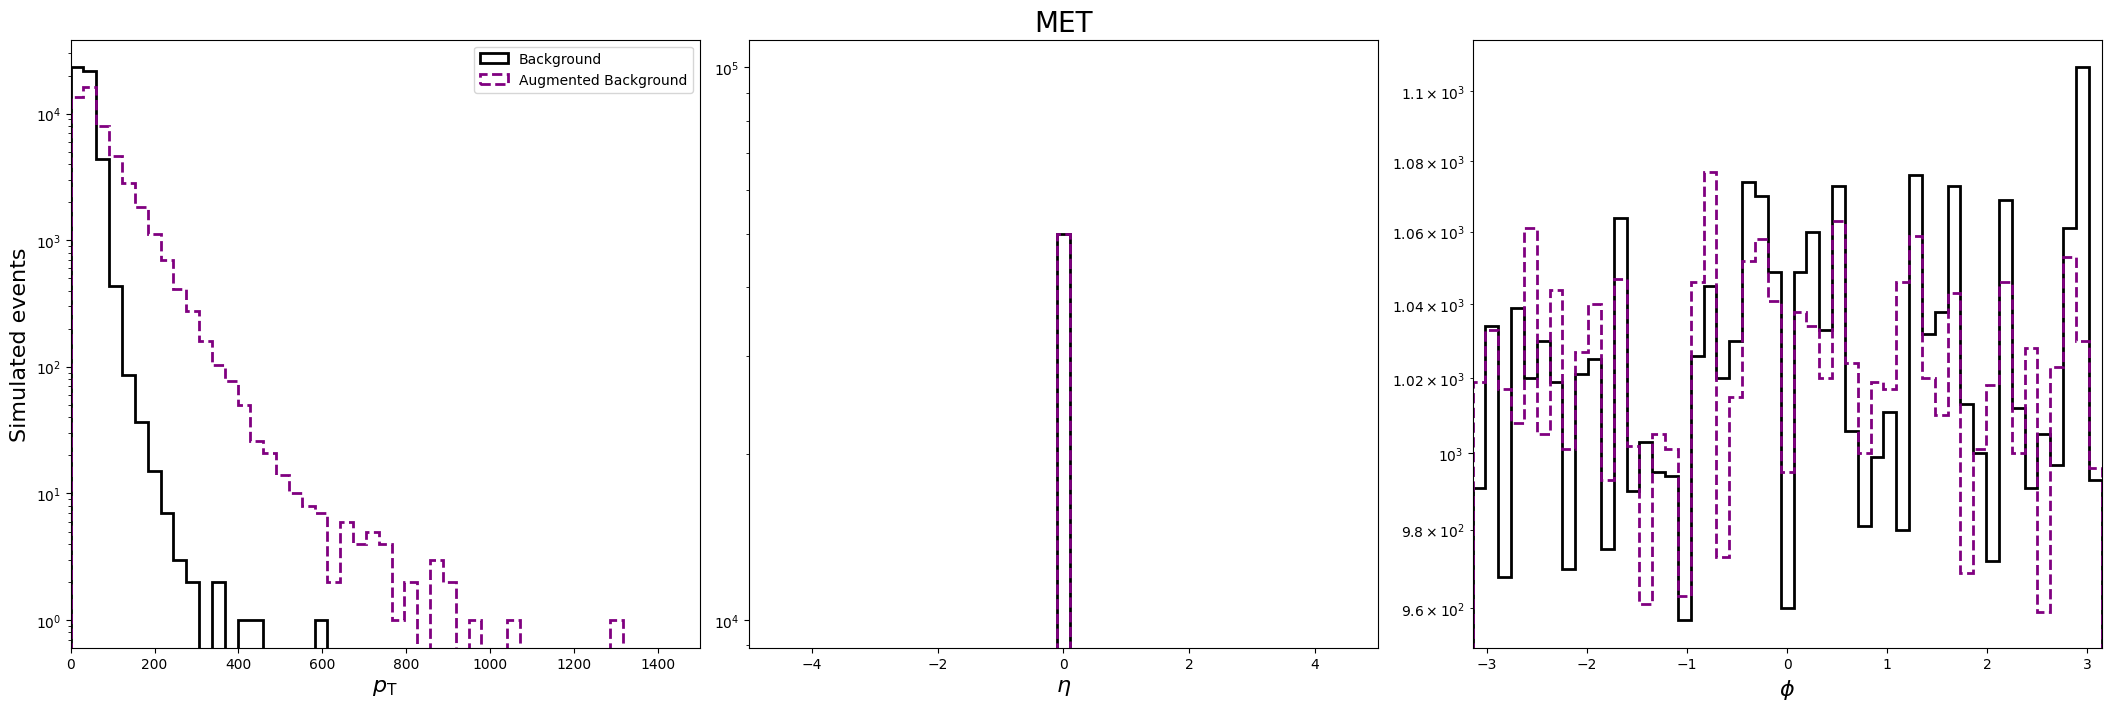

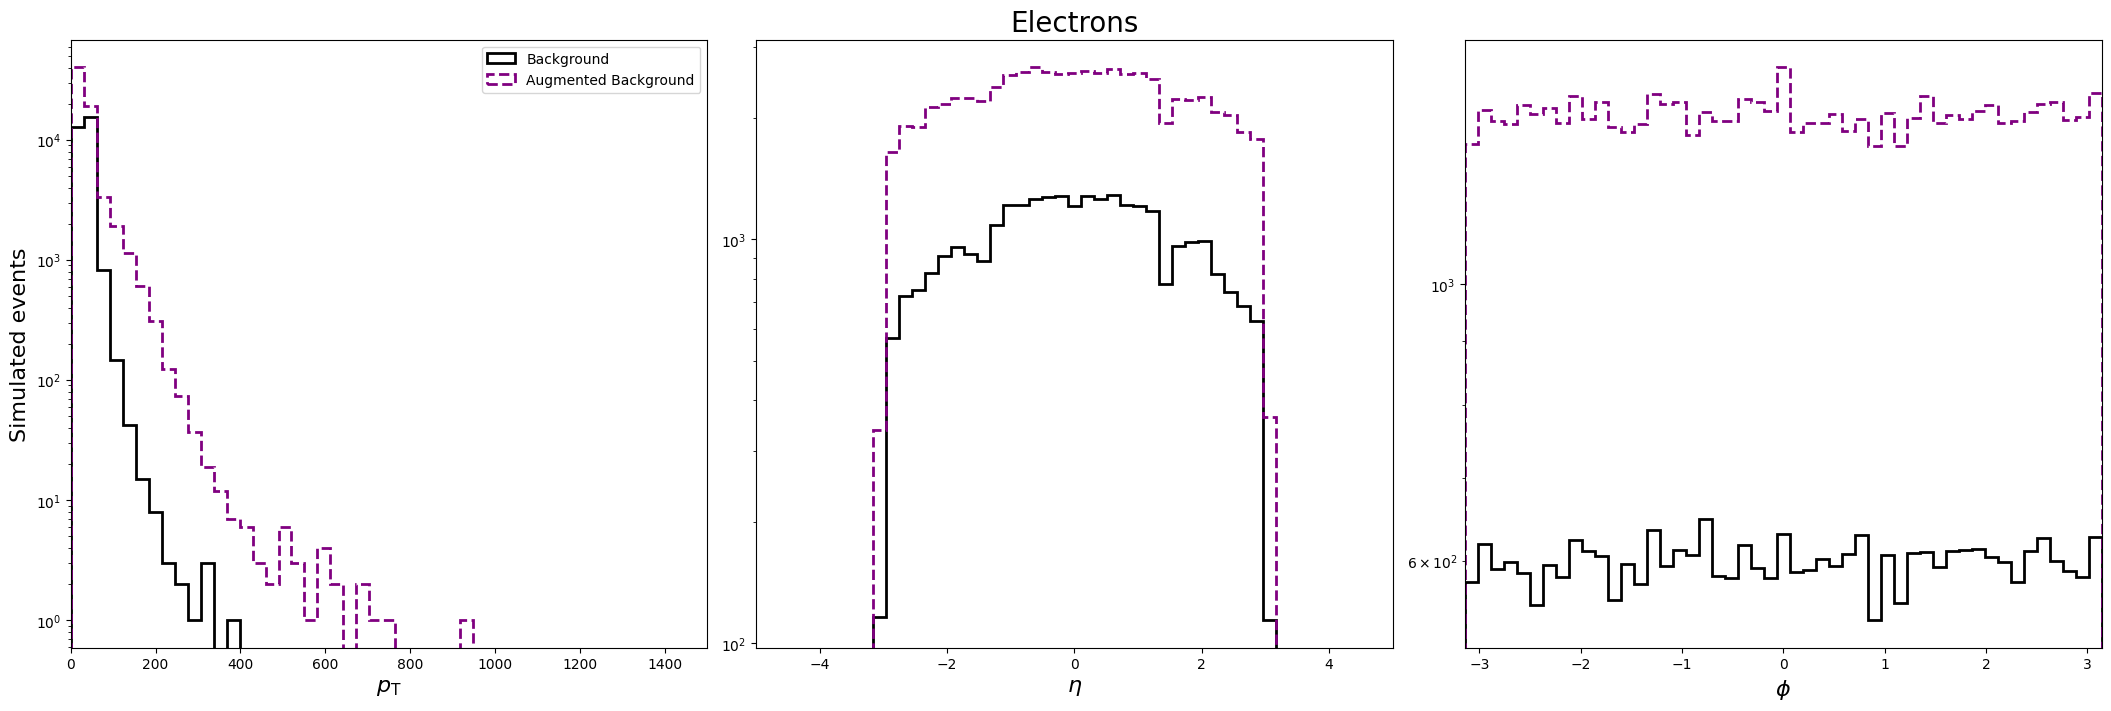

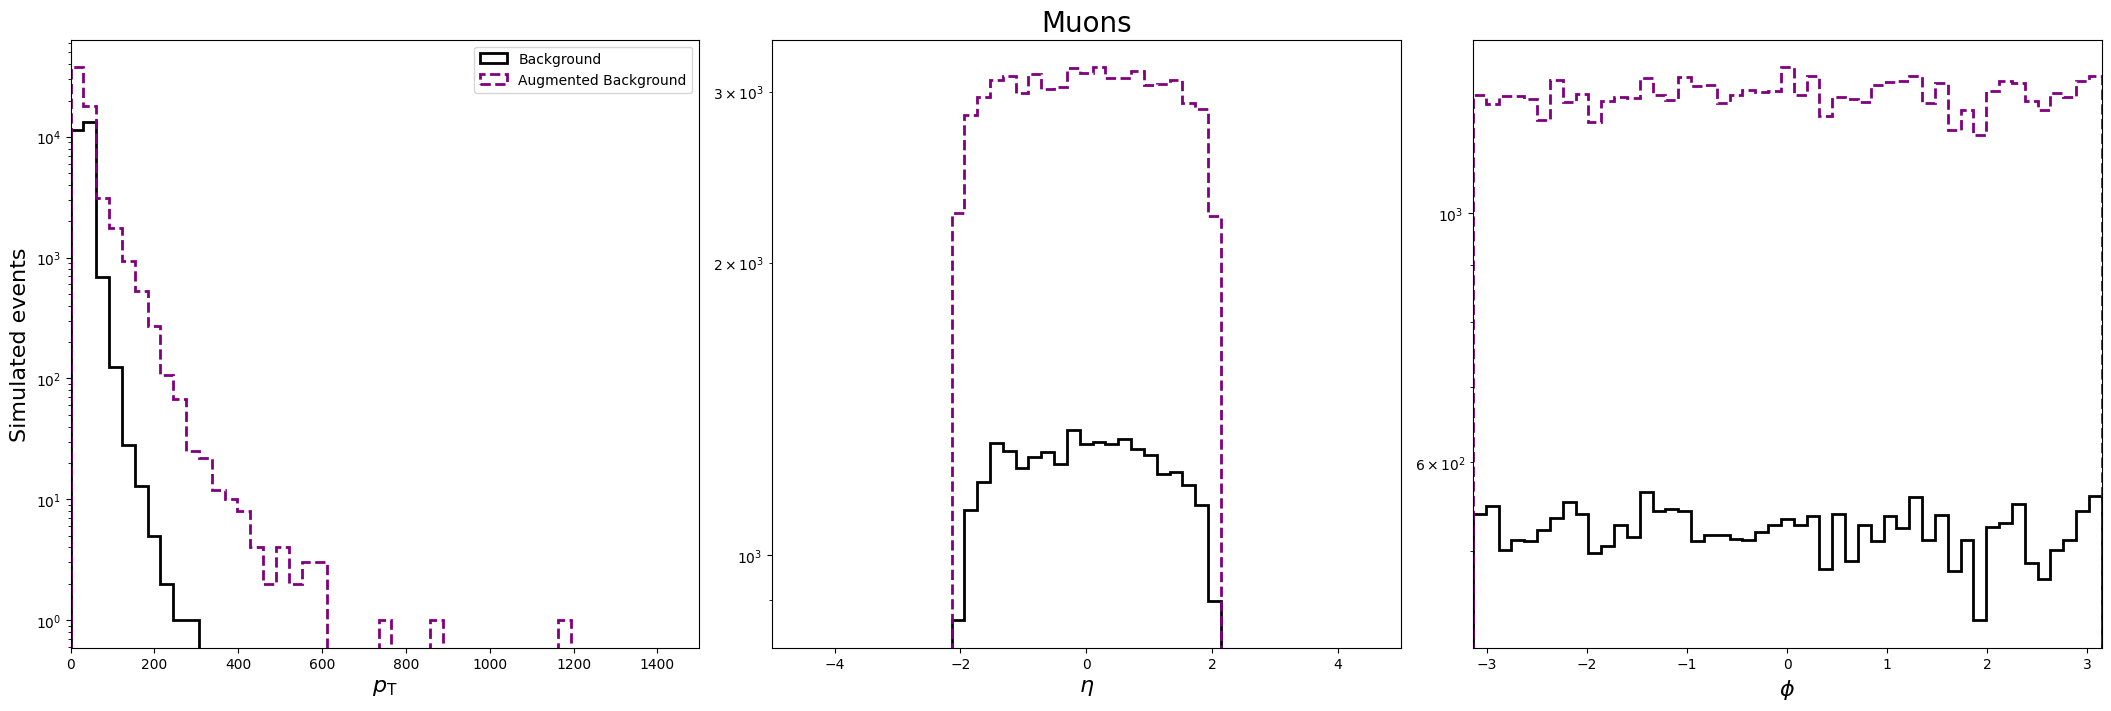

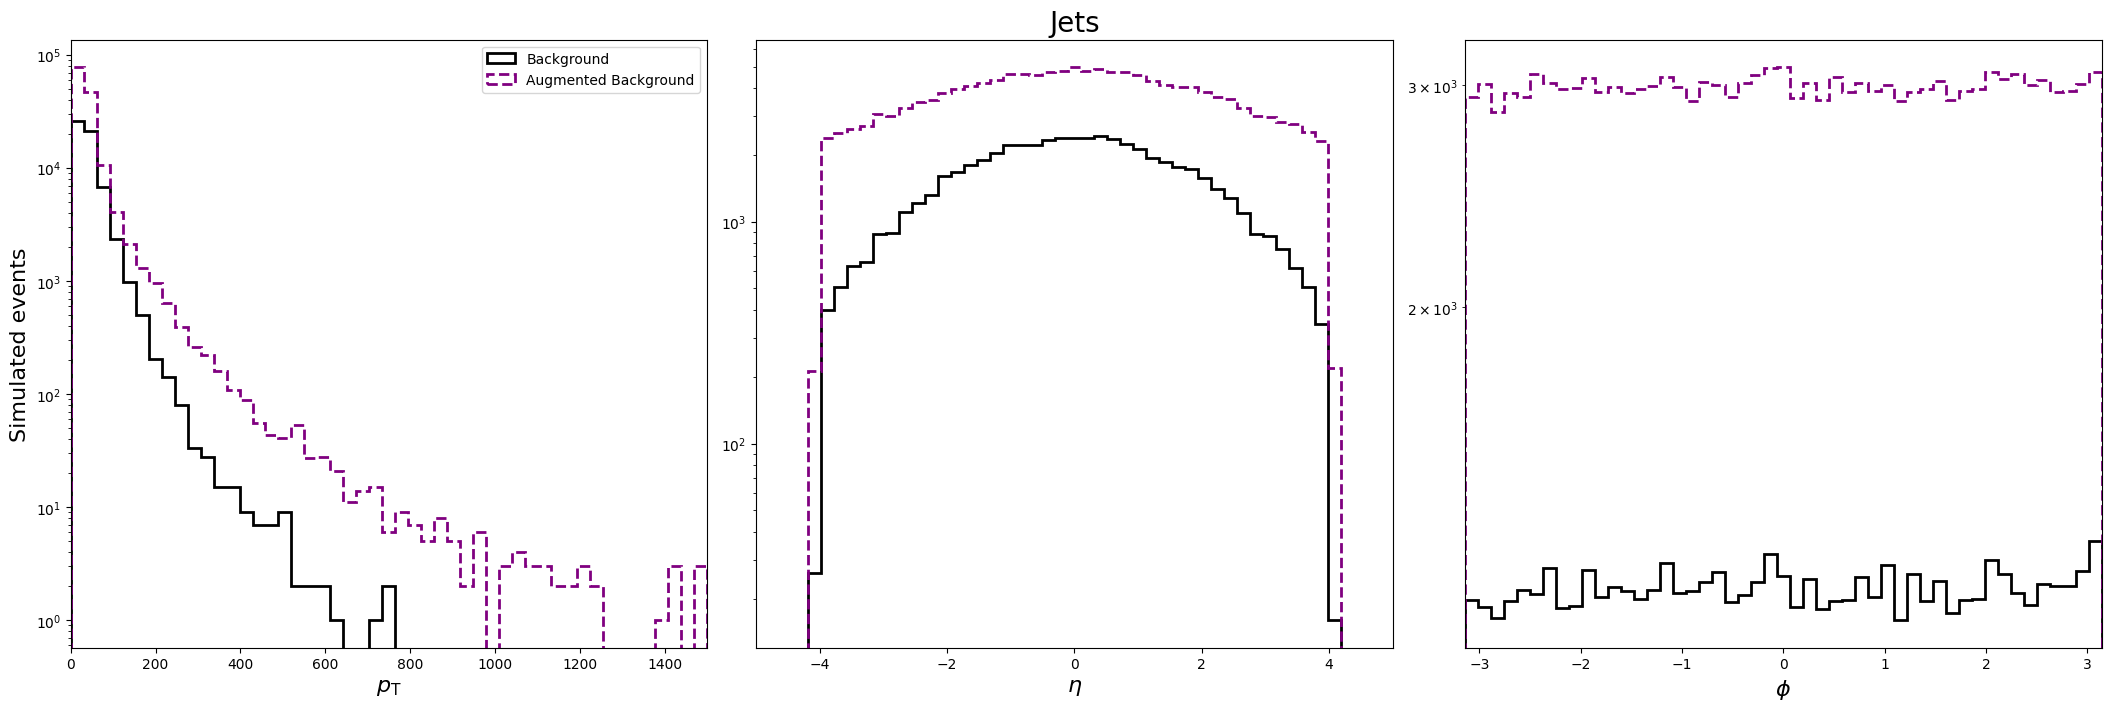

In [ ]:
#-- Visualize the data distribution --#
plotArgDict = {}
plotArgDict['nBins']              = 50
plotArgDict['pltDim']             = (1,3) # i.e. 1 row, 3 columns
plotArgDict['xAxisLimsList']      = [(0, 1500), (-5, 5), (-np.pi, np.pi)]

# MET
plotArgDict['title']              = r'MET'
plotDataAugHists(bkgData[:,0,0:3], newAugBkgData[:,0,0:3], plotArgDict)

# Electrons
plotArgDict['title']              = r'Electrons'
B  = bkgData[:,1:5,0:3].reshape((-1, 3))
AB = newAugBkgData[:,1:5,0:3].reshape((-1, 3))
mask_B   = ~(B[:,0]==0.)
mask_AB  = ~(AB[:,0]==0.)
plotDataAugHists(B[mask_B], AB[mask_AB], plotArgDict)

# Muons
plotArgDict['title']              = r'Muons'
B  = bkgData[:,5:9,0:3].reshape((-1, 3))
AB = newAugBkgData[:,5:9,0:3].reshape((-1, 3))
mask_B   = ~(B[:,0]==0.)
mask_AB  = ~(AB[:,0]==0.)
plotDataAugHists(B[mask_B], AB[mask_AB], plotArgDict)

# Jets
plotArgDict['title']              = r'Jets'
B  = bkgData[:,9:,0:3].reshape((-1, 3))
AB = newAugBkgData[:,9:,0:3].reshape((-1, 3))
mask_B   = ~(B[:,0]==0.)
mask_AB  = ~(AB[:,0]==0.)
plotDataAugHists(B[mask_B], AB[mask_AB], plotArgDict)